## 절차

|절차|단계|목표/설명|
|:-:|:-:|:-|
|1|연구목표|사용자가 입력한 텍스트를 예측하여 어떤 언어인지 판독한다 (영어권 )<br>머신러닝의 사용 여부 판단 (굳이 사용하지 않해도 처리 가능하면 제외 )<br>머신러닝을 적용 , 지도 학습법을 사용 , 알고리즘은 여러개를 테스트하여 최적화가 된 알고리즘을 사용(파라미터 적용)<br>|
|2|데이터 획득/ 수집|실전 : 위키 피디아/소설/법률등 덱스트 크롤링<br>임시: 제공데이터 (법령/대본 등 )|
|3|데이터 준비/ 통찰/ 전처리|텍스트에서 알파벳의 출현 빈도를 계산하여 백터화 <br>훈련데이터 / 테스트 데이터 구성 |
|4|데이터 탐색/통찰/ 시각화|언어별로 알파벳을 출현 /사용빈도가 다르다라는 명제를 확인<br>시각화를 진행, 바차트를 국가별로 비교, 선형차트를 통해서 빈도의 차이점 시각화 |
|5|데이터 모델링 OR 모델 구축|-학습 <br>-예측<br>-정답률<br>-성능 평가 <br>- 알고리즘 체인/ 파이프라인 구축 <br>-하이퍼파라미터튜닝 <br>-연구목표에서 설정한 목표치까지 도달할때까지 반복 |
|6|시스템통합 or (솔루션,서비스,레포트)|-모델을 덤프 -> flask웹서비스 기반에 연동 -> 서비스 구성<br>-모델을 업데이트/다운그레이드가 자동화 할수 있게 구성<br>-선순환구조(사용자가 사용하면 할수록 그 데이터가 다시모여 학습 -> 성능 향상 -> 업데이트|

### 1. 연구목표 [OK]

### 2. 데이터획득/수집
- 영어 샘플사이트 : https://en.wikipedia.org/wiki/BTS_(band)
- .mw-parser-output p  혹은 #mw-content-text p

In [2]:
#2-1. 실전용 : 미국 ,프랑스, 인도네시아, 타갈리아어등의 위키피디아의 텍스트 수집 
#             수집된 정량을 되도록 비슷한 분량으로 준비 
# BeautifulSoup 에서 -> 검색해서 -> html5lib를 설치 한다 . 
# $ apt-get install python-html5lib
# $ easy_install html5lib
# $ pip install html5lib

In [3]:
import urllib.request as req
from bs4 import BeautifulSoup

In [4]:
#2-2. 요청 및 soup로 구성 
target_url = 'https://en.wikipedia.org/wiki/BTS_(band)'
soup       = BeautifulSoup( req.urlopen( target_url ), 'html5lib' )

In [5]:
type(soup)

bs4.BeautifulSoup

In [6]:
#2.3. 데이터 추출 
ouptut = soup.select('#mw-content-text p')
len(ouptut),type(ouptut)

(64, list)

In [7]:
# 2-4 리스트에 모든 텍스트를 담아라(맴버로)
texts = [ t.text for t in ouptut ]
texts[:3]

['\n\n',
 '\n',
 'BTS (Korean:\xa0방탄소년단; RR:\xa0Bangtan Sonyeondan), also known as the Bangtan Boys, is a seven-member South Korean boy band formed in Seoul in 2013. The septet co-writes and produces much of their output. Originally a hip hop group, their musical style has evolved to include a wide range of genres. Their lyrics, often focused on personal and social commentary, touch on the themes of mental health, troubles of school-age youth, loss, the journey towards loving oneself, and individualism. Their work features references to literature and psychological concepts and includes an alternative universe storyline. Popular for their live performances, the group have staged several world tours.\n']

In [8]:
# 통합, 조인 <-> 분해 (의 결과물은 리스트 )
str_text =' '.join(texts)
str_text[:20]

'\n\n \n BTS (Korean:\xa0방탄'

In [9]:
# 영어만 두고 다 날린다. 단, 공백정도는 단어들을 구분하기 위해서 두겟다
# 정규식 => 영어만 > [a-zA-Z ]*
import re

In [10]:
p = re.compile('[^a-zA-Z ]*') 

In [11]:
tmp = p.sub('',str_text)

In [12]:
# 이런 데이터를 대상 언어별로 준비하여 대량의 데이터를 확보한다
# 충분한 학습을 수행하기 위한 재료
# 단, 시간 관계상 수집하는 방법에 대해서 살펴봤고, 이렇게 모아진 데이터를 사용하여
# 학습을 진행할것이다

### 3. 데이터준비/통찰/전처리 + 시각화
+ 제공되는 모든 데이터를 읽어서 처리
+ 알파벳의 빈도를 계산하여 수치화

In [13]:
#파일 목록 리스트
import glob, os.path, re, json

file_list = glob.glob('../data/train/*.txt')
file_list[:2], len(file_list)
file_list

['../data/train\\en-1.txt',
 '../data/train\\en-2.txt',
 '../data/train\\en-3.txt',
 '../data/train\\en-4.txt',
 '../data/train\\en-5.txt',
 '../data/train\\fr-10.txt',
 '../data/train\\fr-6.txt',
 '../data/train\\fr-7.txt',
 '../data/train\\fr-8.txt',
 '../data/train\\fr-9.txt',
 '../data/train\\id-11.txt',
 '../data/train\\id-12.txt',
 '../data/train\\id-13.txt',
 '../data/train\\id-14.txt',
 '../data/train\\id-15.txt',
 '../data/train\\tl-16.txt',
 '../data/train\\tl-17.txt',
 '../data/train\\tl-18.txt',
 '../data/train\\tl-19.txt',
 '../data/train\\tl-20.txt']

In [14]:
#파일을 읽어서 => 빈도를 계산 => 지도방식 데이터로 구성한다면 => 변수(a~z) + 답안 (1개)
def check_lang_freq(file_path):
#-------------------------------------------------------------------------
    # 1.정답 변수(컬럼)을 구성하기 위한 => '../data/train\en-1/*.txt' => en 추출 
    #   정답 추출 
    name = os.path.basename(file_path)
    #file_path를 통찰해보니, 위치가 변경되면 정규직이 정용 안될수 있다. 
     # ^[a-z]{2,}
    p    = re.compile( '^[a-z]{2,}' )
    lang = p.match( name ).group()
#     print( name, lang )
    # file_path를 통찰 해보니, 위치가 변경된면 정규식이 적용 안 될 수 있다.
    # 파일명을 추출하여 거기서 정규식을 적용하는것이 합리적 => 경로가 바뀌어도 Ok
#-------------------------------------------------------------------------
    
#-------------------------------------------------------------------------
    # 알파벳 빈도 계산 
    with open( file_path, 'r', encoding='utf-8' ) as f:
        # 데이터를 들여다 보니 대소문자가 섞여 잇다. 아스키값이 다르니 
        # 한쪽방향으로 통일해야한다. 여기서는 소문자로 통일 
        text = f.read().lower()
        p1   = re.compile( '[^a-zA-Z ]*' )
        text = p1.sub( '' , text )
        #print( text[:100] )
        # 알파벳 순서대로 빈도수를 기록하겠다. 
    cnts = [ 0 for n in range(26) ]
    #   a_>ASCII ~z 값이 순서대로 적용된다.
    asc_a, asc_z, asc_ws = ord('a'), ord('z'), ord(' ')
#         print( asc_a, asc_z, asc_ws )
        #   a-a = 0, b-a = 1,....z-a =25=> 빈도를 기록할 인덱스와 동일 
    for ch in text:
        #ch를 아스키로 변환 
        n = ord(ch)
        if asc_a <= n <= asc_z: # 알파벳이 맞으면 
        # if ord(ch)!= asc_ws: # 공백만 빼고 
            cnts[ n -asc_a ] += 1 # 빈도 증가 
             
    # 2. 파일을 오픈 -> 읽고-> 닫기 -> [0,0,0,0,0,0,0,0....0]
    #   알파벳 순서대로 빈도수를 기록 하겠다. 
    #   a_>ASCII ~z 값이 순서대로 적용된다. 
    # **ord()=> ASCII 환산 함수 
    #   a-a = 0, b-a = 1,....z-a =25=> 빈도를 기록할 인덱스와 동일 
#-------------------------------------------------------------------------

#-------------------------------------------------------------------------
    # 3. 빈도는 파일 한개당 전체 글의 빈도수의 해당 a-z까지의 빈도수로 표현 
    #   => 데이터를 같은구간에 배치 => 정규화 0~1 사이에 배치
    # 전체 빈도 
    total_cnt = sum(cnts)
    freq= list(map(lambda x:x/total_cnt, cnts)) # 한놈한놈 (함수,변수)
#-------------------------------------------------------------------------

#-------------------------------------------------------------------------
    # 4.리턴 : 정답, 빈도를 담은 리스트 
#-------------------------------------------------------------------------
    return lang,freq

In [15]:
# 함수적용한 케이스
for file in file_list:
    lang,freq = check_lang_freq( file )
#     print( lang, sum(freq) ) 

In [16]:
#특정 폴더내의 데이터를 읽어서 빈도로 리턴 
# file_glod = > '../data/train/*.txt'
def load_files(file_glob):
    langs = []
    freqs = []
    file_list = glob.glob(file_glob)
    for file in file_list:
        lang, freq = check_lang_freq(file)
        langs.append(lang)
        freqs.append(freq)
    return {'labels':langs,'freqs':freqs}

In [17]:
# 데이터 로드 
train_data = load_files('../data/train/*.txt')
test_data  = load_files('../data/test/*.txt')

In [18]:
# 데이터 확인
len(train_data['labels']), len(test_data['labels'])

(20, 8)

In [19]:
# 데이터 적제
# 자료구조를 그대로 유지해서 저장 => json 모듈로 처리
with open( '../data/lang_label_freq.json', 'w', encoding='utf-8' ) as f:
    json.dump( [train_data, test_data], f )

In [20]:
for n in 'hellowoeld':
    print(n)

h
e
l
l
o
w
o
e
l
d


### 4.데이터탐색/통찰/시각화

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import json
%matplotlib inline

In [24]:
#데이터 로드 
with open( '../data/lang_label_freq.json', 'r', encoding='utf-8' ) as fp:
    freq = json.load(fp)

In [25]:
#데이터 구조 확인, 데이터 들여다보기 
freq

[{'labels': ['en',
   'en',
   'en',
   'en',
   'en',
   'fr',
   'fr',
   'fr',
   'fr',
   'fr',
   'id',
   'id',
   'id',
   'id',
   'id',
   'tl',
   'tl',
   'tl',
   'tl',
   'tl'],
  'freqs': [[0.07595212187159957,
    0.012840043525571273,
    0.04570184983677911,
    0.04613710554951034,
    0.10533188248095757,
    0.015669205658324265,
    0.019151251360174103,
    0.043743199129488576,
    0.07399347116430903,
    0.0017410228509249185,
    0.00544069640914037,
    0.05375408052230685,
    0.026332970620239392,
    0.07747551686615888,
    0.08966267682263329,
    0.016539717083786723,
    0.0,
    0.07769314472252448,
    0.061371055495103376,
    0.08052230685527748,
    0.02589771490750816,
    0.009793253536452665,
    0.014145810663764961,
    0.0006528835690968443,
    0.02002176278563656,
    0.0004352557127312296],
   [0.08417789436031954,
    0.019911768212710148,
    0.030404196971503518,
    0.038869679265529984,
    0.13699773458924527,
    0.0174078931679980

In [26]:
# 볼륨
#훈련데이터 개수 
len(freq[0]['labels']),len(freq[0]['freqs'])

(20, 20)

In [27]:
# 테스트 데이터 개수 
len(freq[1]['labels']),len(freq[1]['freqs'])

(8, 8)

In [28]:
type(freq[0]['freqs'])

list

In [29]:
#훈련데이터를 바로 df로 변환 
df_freq = pd.DataFrame (freq[0]['freqs'])
df_freq.shape

(20, 26)

In [30]:
df_freq.head(2)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.000000,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.005485,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596


In [33]:
df_label = pd.DataFrame(freq[0]['labels'])
df_label.shape

(20, 1)

In [34]:
df_label.head(2)

,0
0,en
1,en


In [35]:
#df_label의 컬럼명을 0-> 'label'로 수정 
df_label.columns =['label']#혹은 매칭해서 함수를 활용하여 수정도 가능 
df_label.head(2)

,label
0,en
1,en


In [36]:
# df_freq, df_label을 데이터 프레임을 합치시오 => 20x27 형태
df_freq.shape,df_label.shape

((20, 26), (20, 1))

In [37]:
df_tmp = pd.concat( [df_freq, df_label], sort=True, axis=1 )
df_tmp.shape

(20, 27)

In [38]:
df_tmp = pd.merge( df_freq, df_label, left_index=True, right_index=True )
df_tmp.shape

(20, 27)

In [39]:
# 알파벳 문자열 지원
from string import ascii_lowercase
ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [40]:
df_tmp.columns = list(ascii_lowercase) + [ df_tmp.columns[-1] ]

In [41]:
# 0~25라는 컬러명을 a-z까지 대체
# a,b,c ... z, label
df_tmp.columns

Index(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
       'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'label'],
      dtype='object')

In [42]:
# 알파벳을 인덱스로, 국가를 컬럼으로 배치 -> a에 대한 국가별 빈도수 배치 
# 빈도수를 평균내라!! (국가별로)
# df_tmp_pv
df_tmp_pv = df_tmp.pivot_table( columns=df_tmp.label )
df_tmp_pv.head(2)

label,en,fr,id,tl
a,0.075558,0.076183,0.160047,0.210537
b,0.018601,0.013140,0.026276,0.021824


In [43]:
df_tmp_pv.tail(2)

label,en,fr,id,tl
y,0.016232,0.004813,0.012463,0.025048
z,0.000788,0.000915,0.000807,0.001396


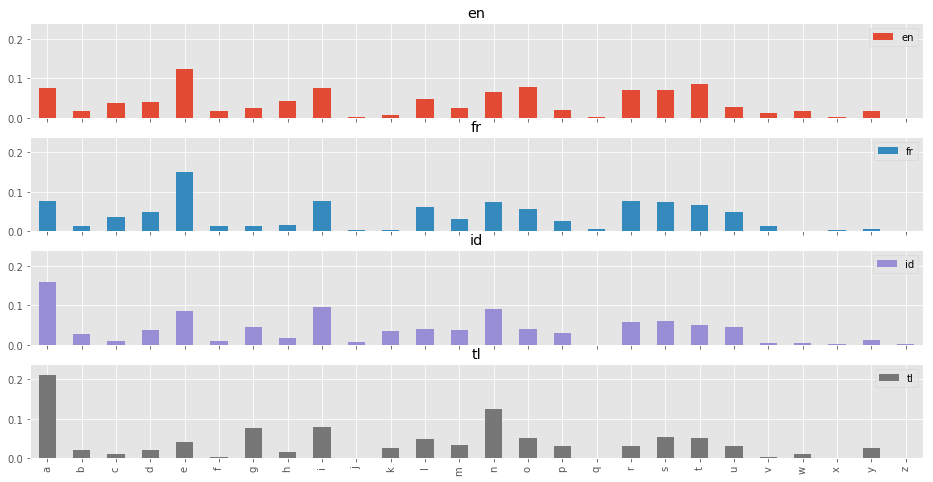

In [45]:
#막대 그래프로 비교 
plt.style.use( 'ggplot' )
df_tmp_pv.plot( kind='bar', subplots=True, figsize=(16,8), ylim=(0,0.24) )
# 저장 
plt.savefig('../data/national_frequence.png')

In [48]:
for word in ascii_lowercase:print(word);break
    #수행문이 두개인데 한줄에 쓰고 싶을때 세미클론을 사용한다. 

a


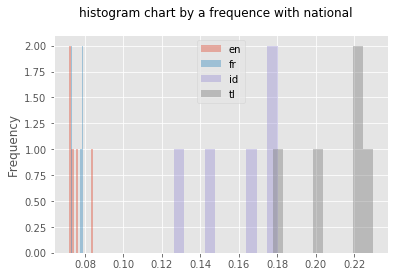

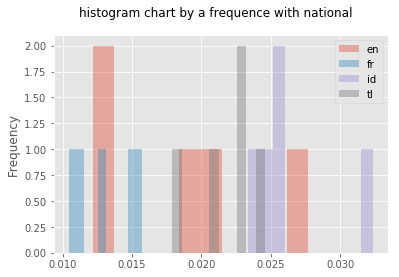

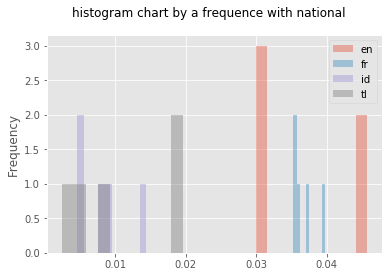

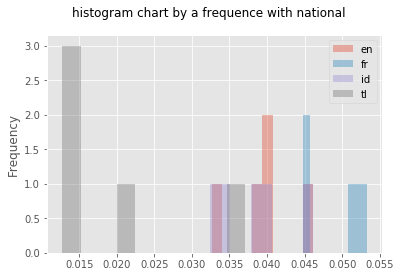

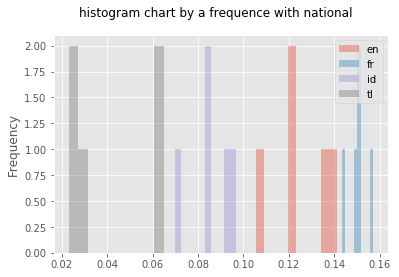

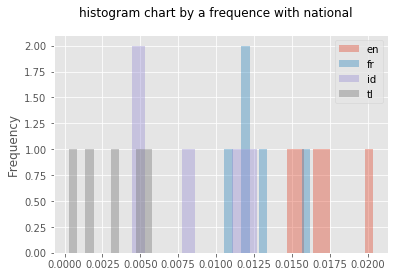

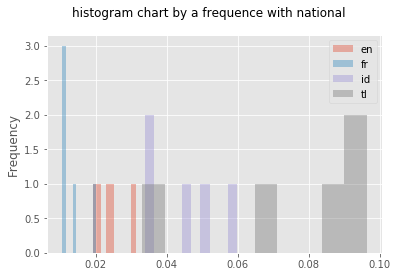

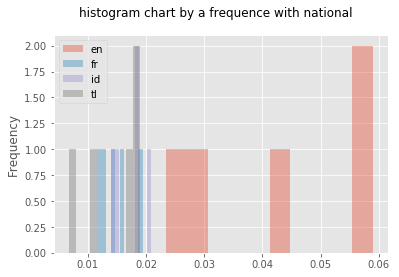

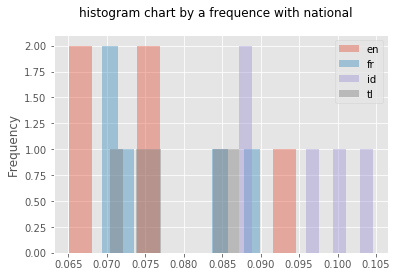

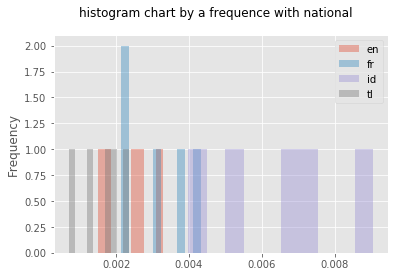

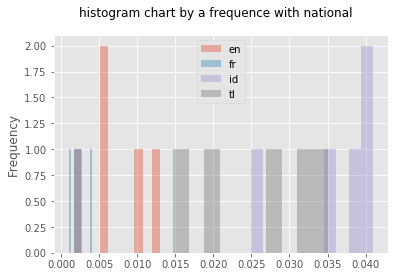

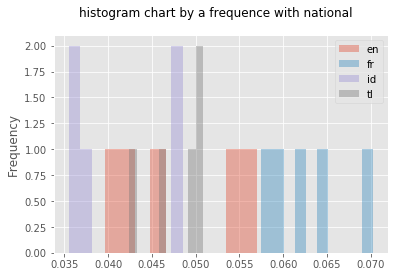

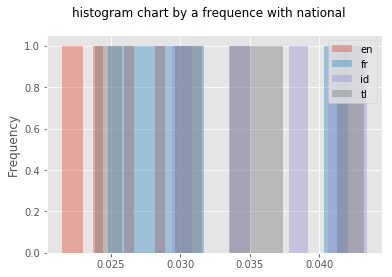

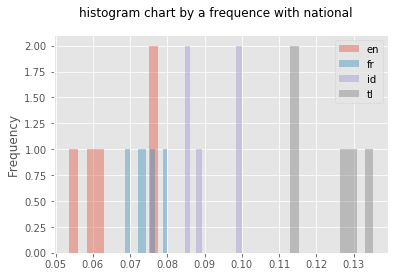

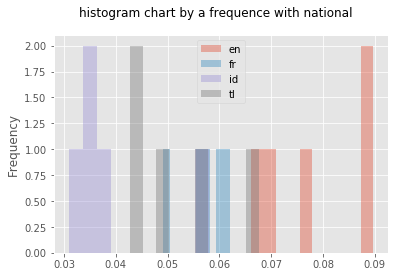

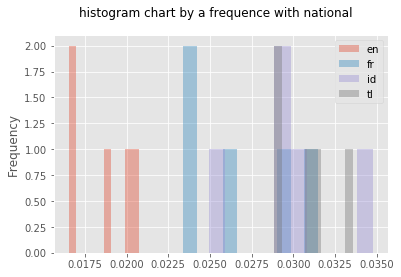

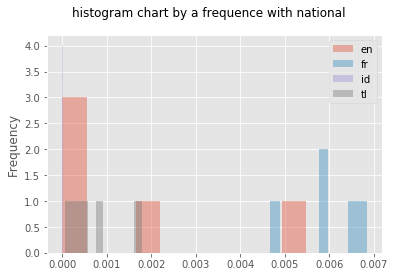

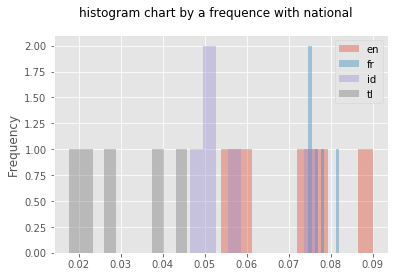

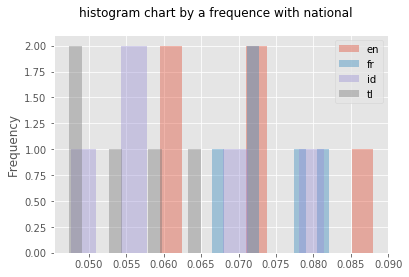

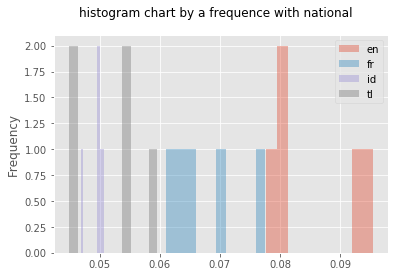

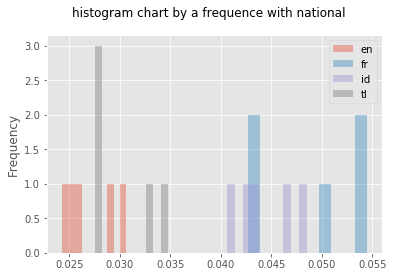

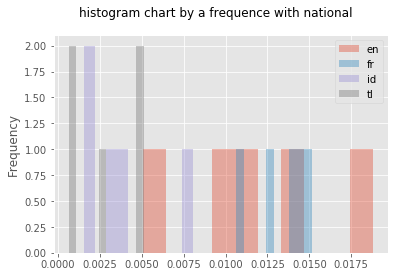

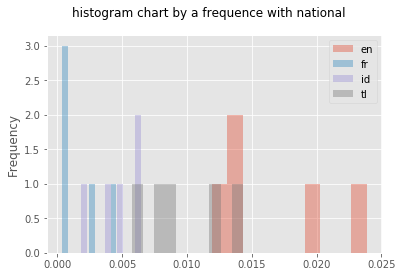

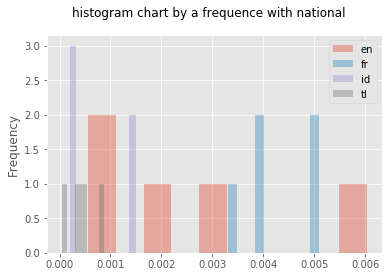

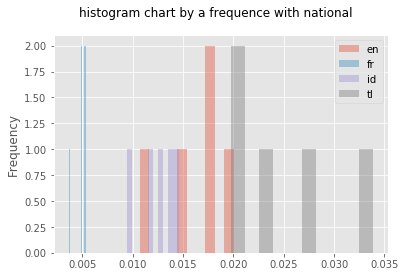

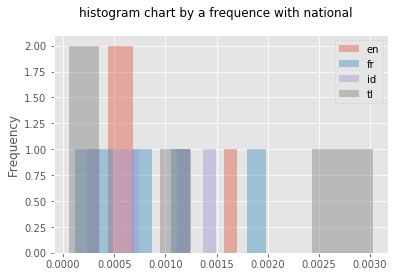

In [50]:
#히스토그램을 이용하여 알파벳 하나에 대한 국가별 비교
#a문자가 국가별 단어에 사용되는 빈도수를 히스토그램을 이용하여 표현
#df_tmp 데이터를 이용하여 a의 빈도를 히스토그램으로 표현하시오 
#데이터를 돌면서 (답안 체크)
for word in ascii_lowercase:
    for na in df_tmp['label'].unique():
        #국가별로 돌면서 
        #1. 해당 국가의 데이터만 확득 
        df_tmp_na = df_tmp[ df_tmp['label'] == na ]
        #print(df_tmp_na) 
        #한번에 그려지는 데이터는 동일한색상으로 처리 
        df_tmp_na[ word ].plot( kind='hist', alpha=0.4, label=na )
    plt.legend()
    plt.suptitle('histogram chart by a frequence with national')
    plt.savefig('../data/%s_freq.png' % (word))
    plt.show()

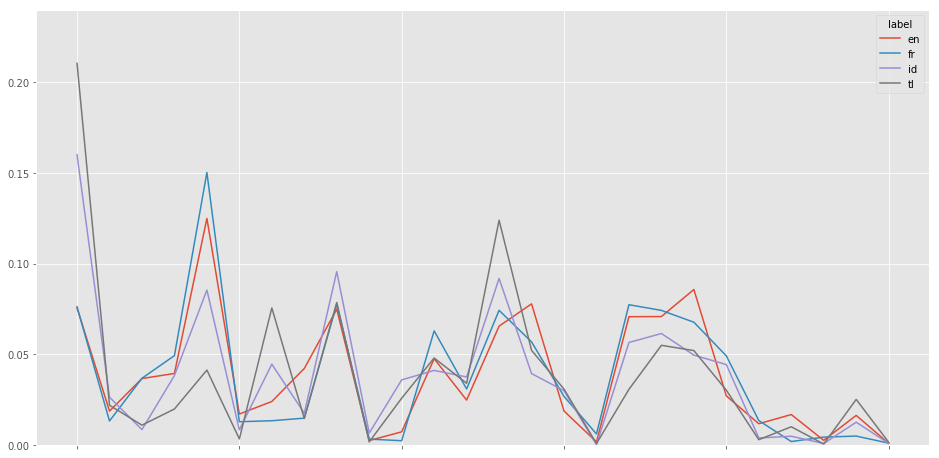

In [53]:
# 한개의 차트에 국가별로 언어 빈도를 연결한다.(선형, line 차트 )
plt.style.use('ggplot')
df_tmp_pv.plot( kind='line', figsize=(16,8), ylim=(0,0.24) )
plt.show()

### 5.데이터모델링 or 모델구축 + 시각화
- 알고리즘 선택
- 훈련용 데이터, 테스트용 데이터 구성 
- 훈련
- 예측모델 생성
- 새로운 데이터를 적용해서 예측\
- 정확도 판단, 검증
- ----------------------------------------------
- 파이프라인구축
- 하이퍼 파라미터 튜닝
- 성능평가

In [54]:
#1. 알고리즘 선택
from sklearn import svm, metrics

In [55]:
#1.1. 해당 알고라즘 객체 생성 
# 생성할때 파라미터를 대입 => 하이퍼 파라미터 => 튜닝, 그 값의 여파로 성능/ 결과치가 변경 
clf = svm.SVC(gamma='auto')

In [ ]:
#2. 훈련데이터, 테스트데이터 구성 
# 이미구성은 되어있고 , 훈련 
# 훈련 함수명이나 , 기타 단위 모듈은 공통적으로 사용할수 있게 인터페이스화 되어 있다. 
#75%,25%분류 

In [56]:
len(train_data['freqs']),len(train_data['labels'])

(20, 20)

In [57]:
#3.훈련
#train_data
#test_data
clf.fit(train_data['freqs'], train_data['labels'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
#4. 예측 모델, 예측 생성, 예측 
#테스트 데이터의 답을 제외한 값을 넣어서 예측 = > 판정 
predict = clf.predict( test_data['freqs'] )

In [61]:
# 예측값 확인
predict

array(['en', 'en', 'fr', 'fr', 'en', 'id', 'tl', 'tl'], dtype='<U2')

In [64]:
# 결과값 확인 
ac_score = metrics.accuracy_score( test_data['labels'], predict )

In [65]:
#훈련량에 비해 잘나욌다. 지향점은 95%~97/8%까지 목표로 잡고, 
#그이상은 과적합 문제에 봉착할수도 있어서 따로 검토
ac_score

0.875

In [66]:
cl_report = metrics.classification_report( test_data['labels'], predict  )
print( cl_report )
# precision : 정밀도
# recall    : 재현율
# f1-score  : 점수, 정확도
# support   : 데이터에 응답한 샘플수

             precision    recall  f1-score   support

         en       0.67      1.00      0.80         2
         fr       1.00      1.00      1.00         2
         id       1.00      0.50      0.67         2
         tl       1.00      1.00      1.00         2

avg / total       0.92      0.88      0.87         8



In [68]:
# 예측 모델을 전달 -> 덤프 (자료구조를 유지하면서 파일로 저장)
from sklearn.externals import joblib
joblib.dump( clf, '../data/clf_lang_20190830.model' )
# 레이블!! (정답의 후보들)
with open('../data/clf_lang_labels.txt', 'w') as f:
    for label in list(set(train_data['labels'])):
          f.writelines( label+'\n' )

### 6.시스템통합 or (솔류션,서비스,레포트)
- flask
- maridb : 데이터 축적, 예측 모델 데이터 업그레드/다운그레이드 정보